# Guía 8: Grid Sampling

Para parámetros $\theta$ contínuos, podemos aproximar la distribución posterior contínua considerando una grilla de valores posibles de los parámetros.

**Receta**:
1. Definir la grilla para $\theta$ (cuántos puntos, con qué intervalo - más puntos es más precisión)
2. Calcular el valor del prior para cada valor de $\theta$ en la grilla
3. Calcular la likelihood para cada valor de $\theta$ de la grilla
4. Calcular la posterior (sin normalizar) para cada valor de $\theta$ multiplicando el prior en ese $\theta$ por la likelihood 
5. Normalizar la distribución dividiendo cada valor de la posterior por la suma (ojo con la integral en el caso contínuo) de todos los valores de la posterior.
6. Tomar muestras de $\theta$ a partir de la posterior


**Pros**: 
* Técnica super simple. Es armar una grilla de valores posibles para $\theta$, y para cada uno calcular prior, likelihood, multiplicar y normalizar.
* No hay que calcular integrales. Trabajar con sampleos transforma un problema de cálculo en un problema de *data summary*. En vez de resolver integrales complicadas, una vez que ya tenes muestras de la distribución, calcular probabilidades es simplemente una cuestión de contar valores en un intervalo.
* Por todo esto es más fácil e intuitivo trabajar con muestras de la posterior, que directamente con probabilididades e integrales.

**Contras**: 
* No es práctica en la vida real ya que escala muy mal con el número de parámetros (complejidad del modelo). Para un solo parámetro no hay problema con grillas de 1000 o 10000 valores, pero para dos parámetros con $1000$ valores cada uno ya aparecen $1.000.000$ valores para calcular (con 10 parámetros ya te vas a $10^{30}$ puntos) 




In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import arviz as az
from scipy.special import comb 

In [28]:
#clase

#data sintetica
trials = 10
sucess = stats.binom.rvs(p=.3, n=trials)

def uniform_prior(theta):
    if not  0 <= theta <= 1:
        raise ValueError
    return 1

In [29]:
def binomial_likelihood(theta, y, n):
    return comb(n,y) * theta ** y * (1 - theta) ** (n-y)

In [30]:
posterior_04 = uniform_prior(0.4) * binomial_likelihood(0.4,  sucess , trials)
print(posterior_04)

0.04031078399999999


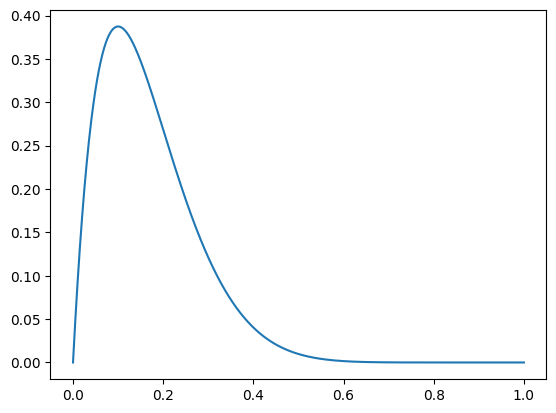

In [31]:
theta_grid = np.linspace(0, 1, 1000)
c_post = []

for theta in theta_grid:
    c_post_i = uniform_prior(theta) * binomial_likelihood(theta,  sucess , trials)
    c_post.append(c_post_i)

fig,ax = plt.subplots()
ax.plot(theta_grid, c_post)

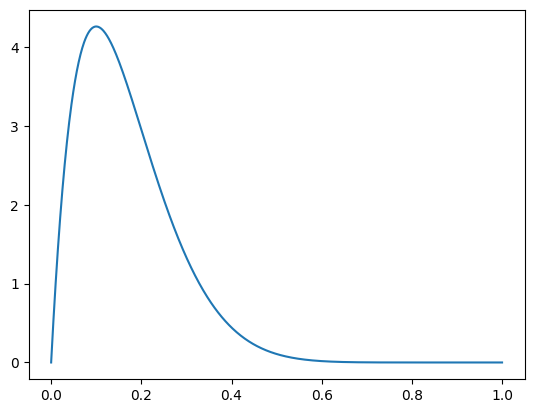

In [49]:
#veo cuanto integra
c_post = np.array(c_post)
post = c_post / (np.sum(c_post) * np.diff(theta_grid)[0])
fig,ax = plt.subplots()
ax.plot(theta_grid, post)

In [54]:
def posterior_binomial(theta_grid, sucesses, trials, prior):
    c_posterior = []
    for theta in theta_grid:
        c_post_i = prior(theta) * binomial_likelihood(theta, sucesses, trials)
        c_posterior.append(c_post_i)
    posterior = c_posterior / (np.sum(c_post) * np.diff(theta_grid)[0])
    return np.array(posterior)

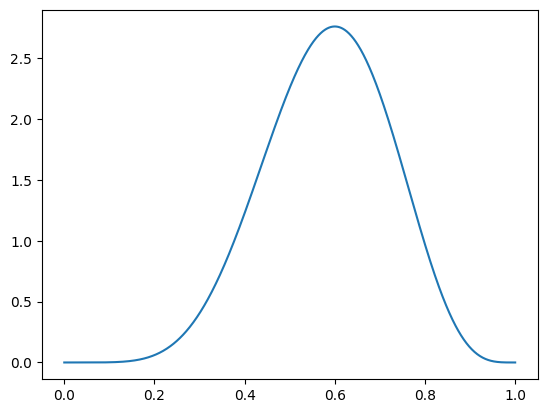

In [56]:
fig,ax = plt.subplots()
posterior = posterior_binomial(theta_grid, 6, 10 ,uniform_prior)
ax.plot(theta_grid, posterior)

(0.0, 1.0)

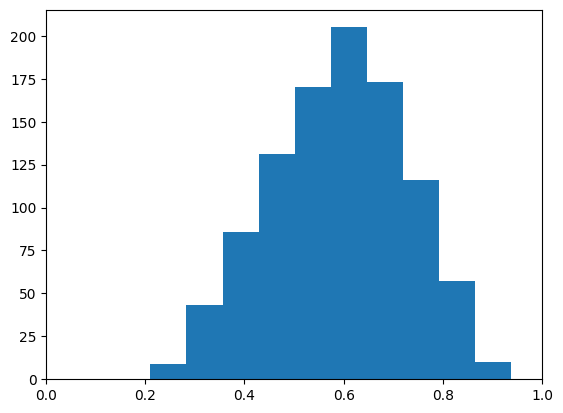

In [59]:
samples = np.random.choice(theta_grid, p=posterior / sum(posterior), size = 1000)
fig,ax = plt.subplots()
ax.hist(samples)
ax.set_xlim(0,1)


In [61]:
print(np.mean(samples))
print(np.median(samples))

0.5882942942942944
0.5955955955955956


me dio paja copiar 


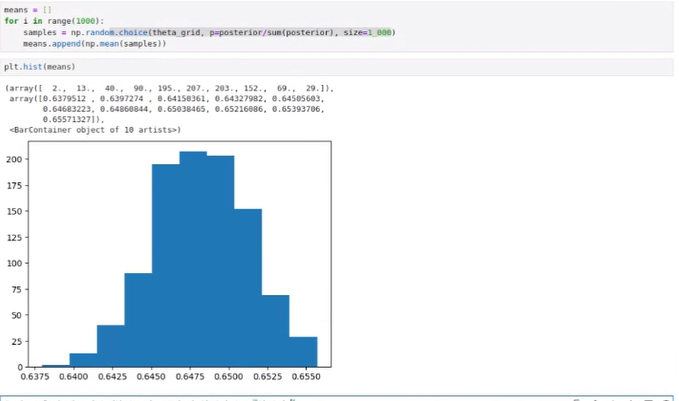

In [68]:
#probabilidad de la siguiente sea cara
samples = np.random.choice(theta_grid, p = posterior / sum(posterior), size = 100000)
number_of_heads = np.sum(np.random.random(size=len(samples)) < samples)

prob = number_of_heads / len(samples)
print(prob)


0.58162


## Ej 1

$$Y \sim Binomial(\theta,n) \hspace{0.5cm} (\text{likelihood})$$
$$\theta \sim U(0,1) \hspace{0.5cm} (\text{prior})$$

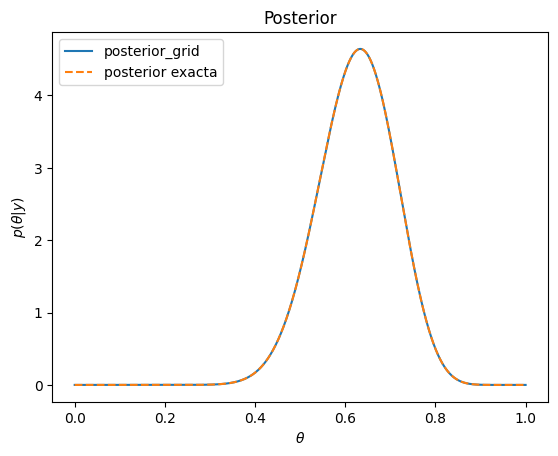

In [32]:
# 1) Defino una grilla de valores posibles para p
theta_grid = np.linspace(0, 1, 1000)

# 2) Defino y calculo el prior
prior_theta = stats.uniform.pdf(theta_grid)

# 3) Calculo la likelihood
y=19
n=30

likelihood_theta = stats.binom.pmf(k=y, n=n, p=theta_grid)

# 4) Calculo la posterior
posterior = prior_theta*likelihood_theta

# 5) Normalizo:
dtheta = np.diff(theta_grid)[0]
posterior /= np.sum(posterior*dtheta)

# Otra forma de normalizar:
# posterior /= np.trapz(posterior, theta_grid)

# Grafico
theta_finito = np.linspace(0, 1, 1000000)
posterior_exacta = stats.beta.pdf(theta_finito, a= y+1, b=n-y+1) #Para comparar grid sampling con la posterior exacta

plt.plot(theta_grid,posterior,label='posterior_grid')
plt.plot(theta_finito,posterior_exacta,'--',label='posterior exacta')
plt.ylabel(r'$p(\theta|y)$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.title('Posterior')
plt.show()

### Sampleo $\theta$ a partir de la posterior

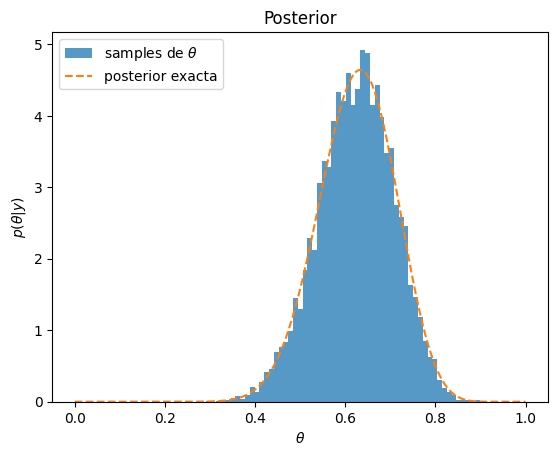

In [33]:
samples = np.random.choice(theta_grid, size=int(1e4), p=posterior*dtheta)

plt.hist(samples, bins='auto',density=True, alpha=0.75,label=r'samples de $\theta$')
plt.plot(theta_finito,posterior_exacta,'--',label='posterior exacta')
plt.ylabel(r'$p(\theta|y)$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.title('Posterior')
plt.show()

### Medidas de resumen de la posterior

#### Estimadores puntuales

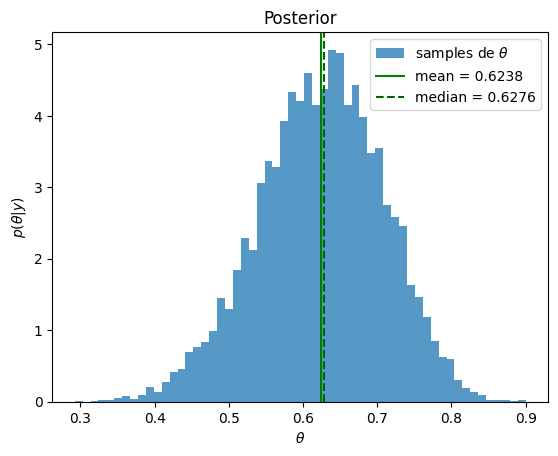

In [34]:
mean = np.mean(samples)
median = np.median(samples)

plt.hist(samples, bins='auto',density=True, alpha=0.75,label=r'samples de $\theta$')
plt.axvline(mean,ls='-',color='g',label=f'mean = {mean:.4f}')
plt.axvline(median,ls='--',color='darkgreen',label=f'median = {median:.4f}')
plt.ylabel(r'$p(\theta|y)$')
plt.xlabel(r'$\theta$')
plt.legend()
plt.title('Posterior')
plt.show()

**PREGUNTA** ¿Cómo calcularían la moda?

#### Intervalos con límites definidos

* ¿Cuánta probabilidad posterior tienen valores menores a tal valor?
  
  **ie**: $P(\theta < c)$
  
* ¿Cuánta probabilidad posterior hay entre dos valores?

  **ie**: $P(a<\theta <b)$


In [35]:
P_1 = np.sum(samples < 0.5) / len(samples) #Fijense que es simplemente sumar todos los que cumplan la condición (y normalizar)
P_2 = (np.sum(samples < 0.75) - np.sum(samples < 0.5)) / len(samples)
print('P(θ < 0.5)', P_1)
print('P(0.25 < θ < 0.75)', P_2)

P(θ < 0.5) 0.0765
P(0.25 < θ < 0.75) 0.8644


#### Intervalos de masa de probabilidad definida (intervalos de confianza)

* ¿Cuál valor del parámetro marca el 5% menor de probabilidad posterior?

  **ie**: $c$ tq $P(\theta < c) = 0.05$
  
* ¿Cuál rango de valores contienen el 90% de la probabilidad posterior?

  **ie**: $a$ y $b$ tq $P(a < \theta < b) = 0.90$


In [36]:
#Intervalo percentil
PI_90 = [np.quantile(samples, 0.05),np.quantile(samples,0.95)]
print('PI 90% =', np.round(PI_90,4))

PI 90% = [0.4805 0.7568]


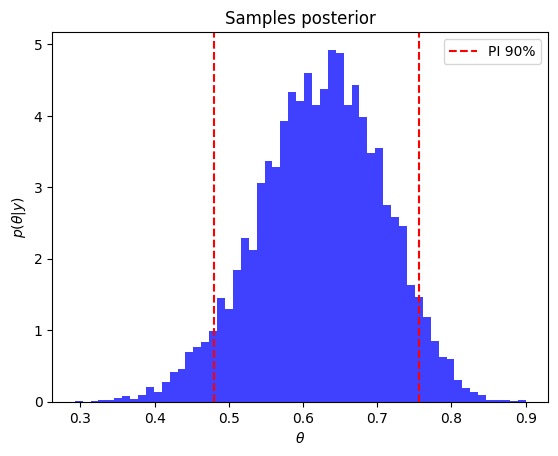

In [37]:
plt.hist(samples, bins='auto', density=True, alpha=0.75, color='blue')
plt.axvline(PI_90[0],ls='--',color='r',label='PI 90%')
plt.axvline(PI_90[1],ls='--',color='r')
plt.ylabel(r'$p(\theta|y)$')
plt.xlabel(r'$\theta$')
plt.title('Samples posterior')
plt.legend()

#### Highest posterior density interval (HPDI)

Es el intervalo más angosto que contiene la probabilidad especificada (es decir, el intervalo que encierra la densidad de probabilidad más alta). Tiene algunas ventajas respecto al PI pero en muchos casos ambos son similares. Cuando la posterior es simétrica y unimodal es casi lo mismo.

HDI 90% =  [0.48948949 0.76376376]


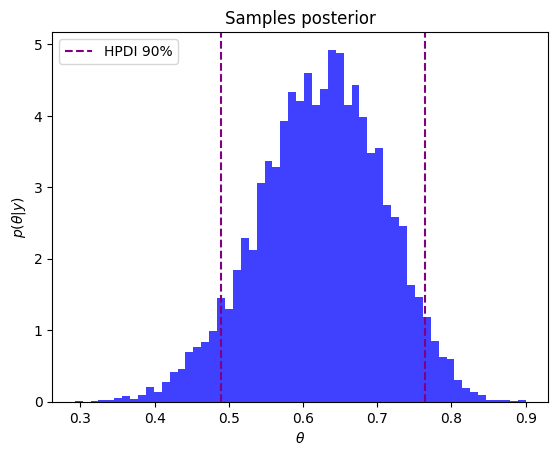

In [38]:
#HPDI
hpdi_90 = az.hdi(samples,hdi_prob=0.9)
print('HDI 90% = ',hpdi_90)

plt.hist(samples, bins='auto', density=True, alpha=0.75, color='blue')
plt.axvline(hpdi_90[0],ls='--',color='purple',label='HPDI 90%')
plt.axvline(hpdi_90[1],ls='--',color='purple')
#plt.axvline(PI_90[0],ls='--',color='r',label='PI 90%')
#plt.axvline(PI_90[1],ls='--',color='r')
plt.ylabel(r'$p(\theta|y)$')
plt.xlabel(r'$\theta$')
plt.title('Samples posterior')
plt.legend()



**EJERCICIO:** Cambien la likelihood por una asimétrica (por ejemplo y=30, n=30) y repitan todo comparando los distintos estimadores puntuales (media vs mediana) y los distintos intervalos de confianza (PI-70% vs HPDI-70%) 

### Posterior predictiva

#### Mal hecha: elijo un estimador puntual de $\theta$ (la media por ejemplo) y sampleo valores de $\tilde{y}$ a partir de ahí

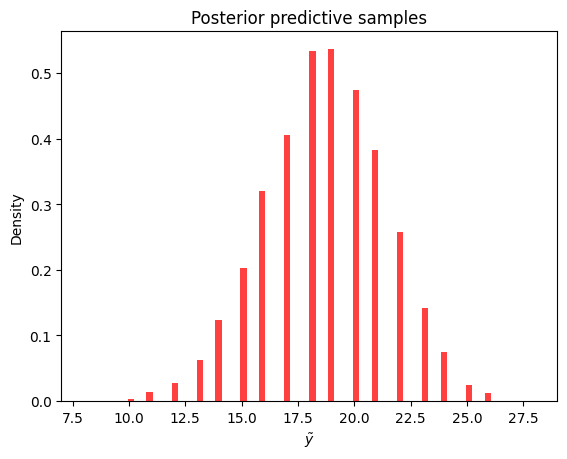

In [39]:
samples_pred_mal = stats.binom.rvs(n=30, p=mean, size=10000)

plt.hist(samples_pred_mal, bins='auto', density=True, alpha=0.75, color='red')
plt.xlabel(r'$\tilde{y}$')
plt.ylabel('Density')
plt.title('Posterior predictive samples')
plt.show()

**¿Por qué está mal?**

Recordemos que para hacer predicciones de observaciones hipotéticas $\tilde{y}$, aparecen dos tipos de incerteza:
* Incerteza en las observaciones para un dado $\theta$. Viene de la naturaleza aleatoria de la variable a observar, cuya distribución depende de $\theta$.
* Incerteza acerca de $\theta$. La cual se manifiesta en su distribución posterior $p(\theta|y)$.

En el gráfico de arriba, al elegir un estimador puntual de $\theta$ estamos ignorando la incerteza asociada a ese parámetro. Para tener en cuenta esa incerteza, hay que integrar sobre todos los valores posibles de $\theta$ usando la distribución posterior: esta es la manera correcta de obtener una distribución posterior predictiva


#### Bien hecha (considerando la incerteza de $\theta$, promediando por sobre sus valores)

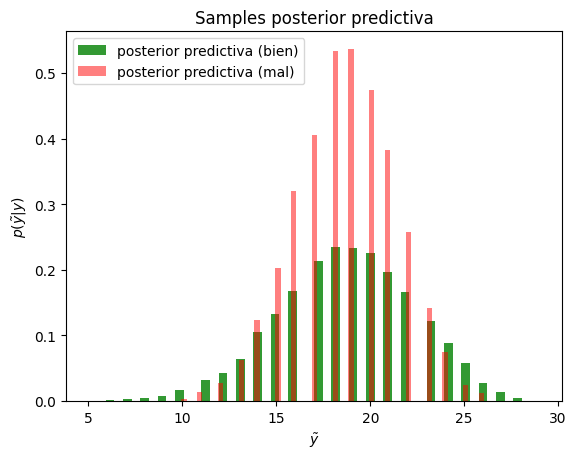

In [40]:
samples_pred = stats.binom.rvs(n=30, p=samples, size=10000)

# Grafico las muestras
plt.hist(samples_pred, bins='auto', density=True, alpha=0.8, color='green',label='posterior predictiva (bien)')
plt.hist(samples_pred_mal, bins='auto', density=True, alpha=0.5, color='red',label='posterior predictiva (mal)')
plt.ylabel(r'$p(\tilde{y}|y)$')
plt.xlabel(r'$\tilde{y}$')
plt.title('Samples posterior predictiva')
plt.legend()

En la figura se ve que el histograma computado usando un único valor de $\theta$ produce una distribución demasiado confiada de las predicciones, es decir, con poca varianza y más angosta que la posterior predictiva verdadera. Esto lleva a que creamos que el modelo es más consistente con los datos de lo que realmente es, por haber tirado a la basura la incerteza sobre $\theta$.

Abajo, usando la posterior predictiva correcta, calculo su HPDI

HDI 90% =  [13 24]


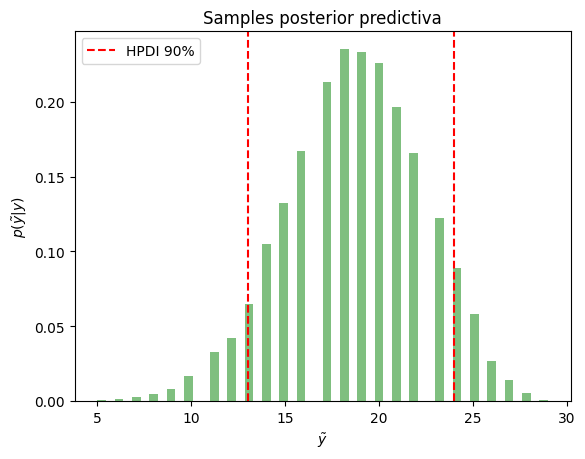

In [41]:
hpdi_pred = az.hdi(samples_pred,hdi_prob=0.9)
print('HDI 90% = ',hpdi_pred)

# Grafico las muestras
plt.hist(samples_pred, bins='auto', density=True, alpha=0.5, color='green')
plt.axvline(hpdi_pred[0],ls='--',color='r',label='HPDI 90%')
plt.axvline(hpdi_pred[1],ls='--',color='r')
plt.ylabel(r'$p(\tilde{y}|y)$')
plt.xlabel(r'$\tilde{y}$')
plt.title('Samples posterior predictiva')
plt.legend()

#### ¿Es una distribución binomial?
Si preguntamos es obvio que no, pero ¿por qué no?

No es una distribución binomial ya que integra por sobre todos los $\theta$ posibles de acuerdo a la posterior. Matemáticamente:

$$p(\tilde{y}|y) = \int_0^1 p(\tilde{y}|y,\theta)p(\theta|y)d\theta $$
$$p(\tilde{y}|y) = \int_0^1 p(\tilde{y}|\theta)p(\theta|y)d\theta $$

por ser los dos experimentos independientes dado $\theta$

$$p(\tilde{y}|y) = \int_0^1 Bi(\tilde{y}|\theta,n)Beta(y+1,n-y+1)d\theta $$
y esta expresión define una distribución beta-binomial

### Probabilidad de obtener $k$ éxitos en 10 experimentos

Text(0.5, 1.0, 'Samples posterior predictiva')

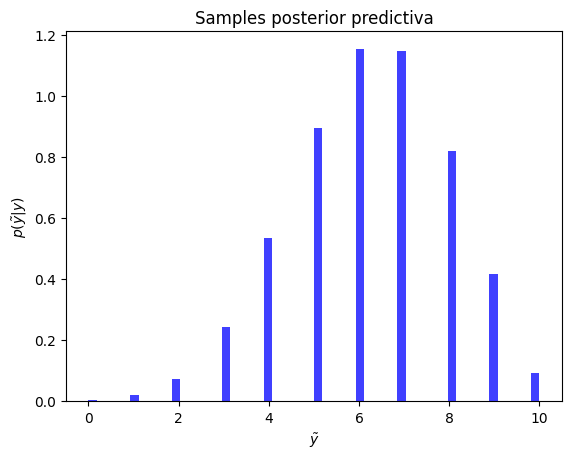

In [42]:
samples_pred = stats.binom.rvs(n=10, p=samples, size=10000)

# Grafico las muestras
plt.hist(samples_pred, bins='auto', density=True, alpha=0.75, color='blue')
plt.ylabel(r'$p(\tilde{y}|y)$')
plt.xlabel(r'$\tilde{y}$')
plt.title('Samples posterior predictiva')

## Ej 2

P(θ < 0.5) 0.0361
P(0.25 < θ < 0.75) 0.8981
PI 90% [0.5075075075075075, 0.7587587587587588]
HDI 90% (posterior) =  [0.5005005  0.75075075]
HDI 90% (posterior predictiva) =  [13 24]


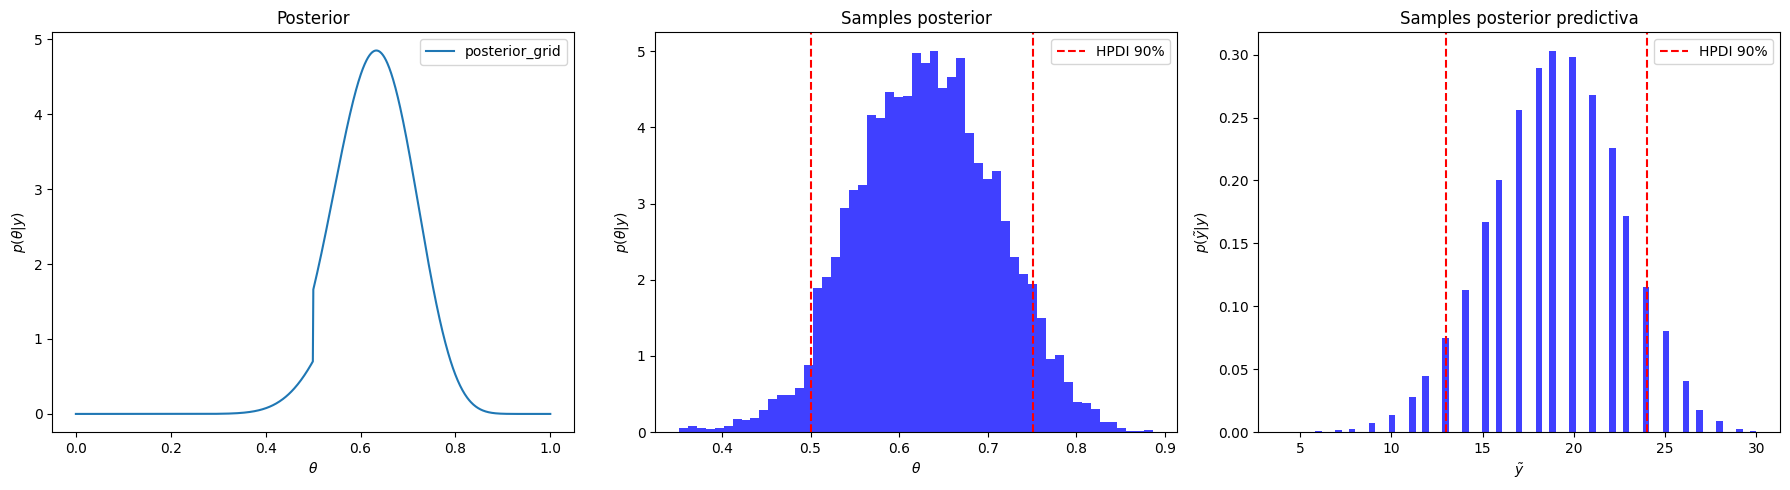

In [43]:
# (a) Defino una grilla de valores posibles para p
theta_grid = np.linspace(0, 1, 1000)

# (b) Calculo la likelihood
y = 19
n = 30
likelihood_theta = stats.binom.pmf(k=y, n=n, p=theta_grid)

# Defino el prior nuevo
prior_theta = np.zeros_like(theta_grid)
prior_theta[theta_grid <= 0.5] = 0.3
prior_theta[theta_grid > 0.5] = 0.7

# (c) Calculo la posterior y normalizo
posterior = prior_theta*likelihood_theta
dtheta = np.diff(theta_grid)[0]
posterior /= np.sum(posterior*dtheta)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Posterior grid
axes[0].plot(theta_grid, posterior, label='posterior_grid')
axes[0].set_ylabel(r'$p(\theta|y)$')
axes[0].set_xlabel(r'$\theta$')
axes[0].set_title('Posterior')
axes[0].legend()

########################################################################################################

# (e) Genero muestras de la posterior
samples = np.random.choice(theta_grid, size=int(1e4), p=posterior*dtheta)

#Intervalos con límites definidos
P_1 = np.sum(samples < 0.5) / len(samples)
P_2 = (np.sum(samples < 0.75) - np.sum(samples < 0.5)) / len(samples)
print('P(θ < 0.5)', P_1)
print('P(0.25 < θ < 0.75)', P_2)

#Intervalo percentil
PI_90 = [np.quantile(samples, 0.05),np.quantile(samples,0.95)]
print('PI 90%', PI_90)

#HPDI
hpdi_90 = az.hdi(samples,hdi_prob=0.9)
print('HDI 90% (posterior) = ',hpdi_90)

# Plot 2: Muestras de la posterior
axes[1].hist(samples, bins='auto', density=True, alpha=0.75, color='blue')
axes[1].axvline(hpdi_90[0], ls='--', color='r', label='HPDI 90%')
axes[1].axvline(hpdi_90[1], ls='--', color='r')
axes[1].set_ylabel(r'$p(\theta|y)$')
axes[1].set_xlabel(r'$\theta$')
axes[1].set_title('Samples posterior')
axes[1].legend()

# Genero muestras de la posterior predictiva
samples_pred = stats.binom.rvs(n=30, p=samples, size=10000)

hpdi_pred = az.hdi(samples_pred,hdi_prob=0.9)
print('HDI 90% (posterior predictiva) = ', hpdi_pred)

# Plot 3: Muestras de la posterior predictiva
axes[2].hist(samples_pred, bins='auto', density=True, alpha=0.75, color='blue')
axes[2].axvline(hpdi_pred[0], ls='--', color='r', label='HPDI 90%')
axes[2].axvline(hpdi_pred[1], ls='--', color='r')
axes[2].set_ylabel(r'$p(\tilde{y}|y)$')
axes[2].set_xlabel(r'$\tilde{y}$')
axes[2].set_title('Samples posterior predictiva')
axes[2].legend()

plt.tight_layout()
plt.show()


## Ej 5 (normal)

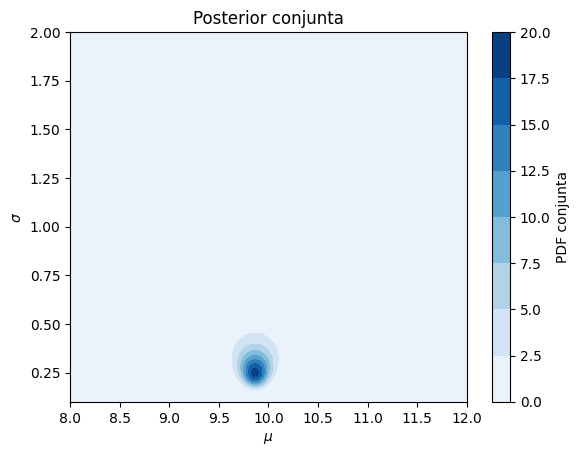

In [44]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import arviz as az

# DATOS
data = np.array([10.3, 9.5, 10.1, 9.7, 10.0, 9.6]) 
n = len(data)

# GRILLAS
mu_grid = np.linspace(8, 12, 200)
sigma_grid = np.linspace(0.1, 2, 200)


#PRIORS
prior_mu = np.ones(len(mu_grid)) # Prior uniforme en mu

prior_sigma = np.ones(len(sigma_grid)) / sigma_grid**2  # Prior uniforme en log(sigma^2)

prior = np.outer(prior_mu, prior_sigma) # Prior conjunto (matriz de 200*200)


# VEROSIMILITUD
likelihood = np.zeros((len(mu_grid), len(sigma_grid)))

for i, mu in enumerate(mu_grid):
    for j, sigma in enumerate(sigma_grid):
        likelihood[i, j] = np.prod(stats.norm.pdf(data, loc=mu, scale=sigma))


#POSTERIOR
posterior = likelihood * prior
dmu = np.diff(mu_grid)[0]
dsigma = np.diff(sigma_grid)[0]
posterior /= np.sum(posterior*dmu*dsigma)

plt.contourf(mu_grid, sigma_grid, posterior.T, cmap='Blues')
plt.colorbar(label='PDF conjunta')
plt.xlabel(r'$\mu$')
plt.ylabel(r'$\sigma$')
plt.title('Posterior conjunta')
#plt.xlim(9,11)
#plt.ylim(0.1,0.6)
plt.show()

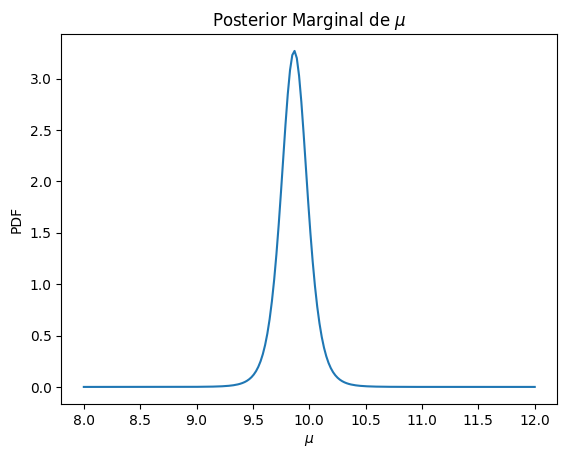

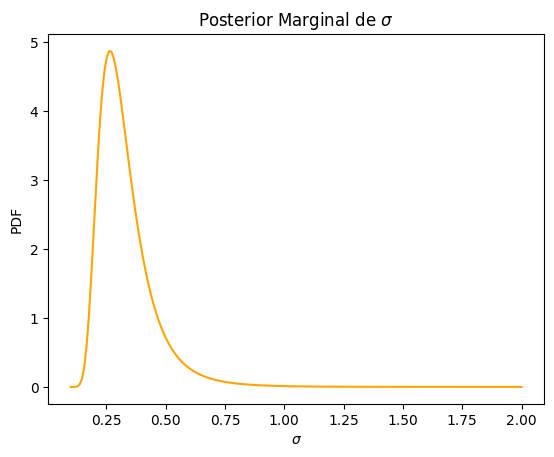

In [45]:
# Marginal para mu
posterior_mu = np.sum(posterior*dsigma, axis=1)

# Marginal para sigma
posterior_sigma = np.sum(posterior*dmu, axis=0)

plt.plot(mu_grid, posterior_mu, label=r'Posterior de $\mu$')
plt.xlabel(r'$\mu$')
plt.ylabel('PDF')
plt.title(r'Posterior Marginal de $\mu$')
plt.show()

plt.plot(sigma_grid, posterior_sigma, label=r'Posterior de $\sigma$', color='orange')
plt.xlabel(r'$\sigma$')
plt.ylabel('PDF')
plt.title(r'Posterior Marginal de $\sigma$')
plt.show()